In [4]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py
import time

import os
from dotenv import load_dotenv
from sklearn.utils import compute_class_weight

load_dotenv()

from data_manipulation.reading_util import load_ml_data_emb
from data_manipulation.reading_util import load_non_enz_esm2
import seaborn as sns

# Loading Embeddings and labeling

In [6]:
enzyme_csv_path = os.getenv("CSV30_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_30")

non_enzymes_esm2_path = os.getenv("ESM2_NON_ENZYMES")
non_enzymes_fasta_path = os.getenv("FASTA_NON_ENZYMES")


# Load enzymes
X_enzymes, y_enzymes = load_ml_data_emb(path_to_esm2=esm2_enzymes_path, path_to_enzyme_csv=enzyme_csv_path)

y_enzymes = [y-1 for y in y_enzymes]
y_enzymes = np.array(y_enzymes)


# Load non_enzymes
X_non_enzymes, y_non_enzymes = load_non_enz_esm2(non_enzymes_fasta_path=non_enzymes_fasta_path,
                             non_enzymes_esm2_path=non_enzymes_esm2_path)


print(len(X_enzymes))
print(len(X_non_enzymes))

y_enzymes = np.array([y+1 for y in y_enzymes])


LOG:
 3 Sequences with aa O in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 15 Sequences with aa U in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 203 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/data/enzymes/csv/split30.csv
LOG:
 221 entries will be ignored
Total count:  288
LOG:
 Data loaded in: 1.062 min
LOG:
 ESM2 of enzymes: 8983
LOG:
 Labels of enzymes: 8983
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG:
 17 Sequences with aa U in /home/malte/Desktop/Dataset/data/non_enzyme/fasta/no_enzyme_train.fasta
LOG:
 2138 non enzymes are longer than 1022 cutoff
LOG:
 2155 entries will be ignored
LOG:
 Non Enzymes data loaded in: 4.878 min
LOG:
 ESM2 of non enzymes: 37347
LOG:
 Labels of non enzymes: 37347
8983
37347


In [4]:

y_non_enzymes = np.array(y_non_enzymes)


## Append X_n and y_n to X and y:

In [5]:
#X = np.vstack((X_enzymes, X_non_enzymes))
#y = np.hstack((y_enzymes, y_non_enzymes))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
#y = np.array([label-1 for label in y])

In [6]:
# np.argmin(y)



array([2, 0, 2, ..., 7, 7, 7])

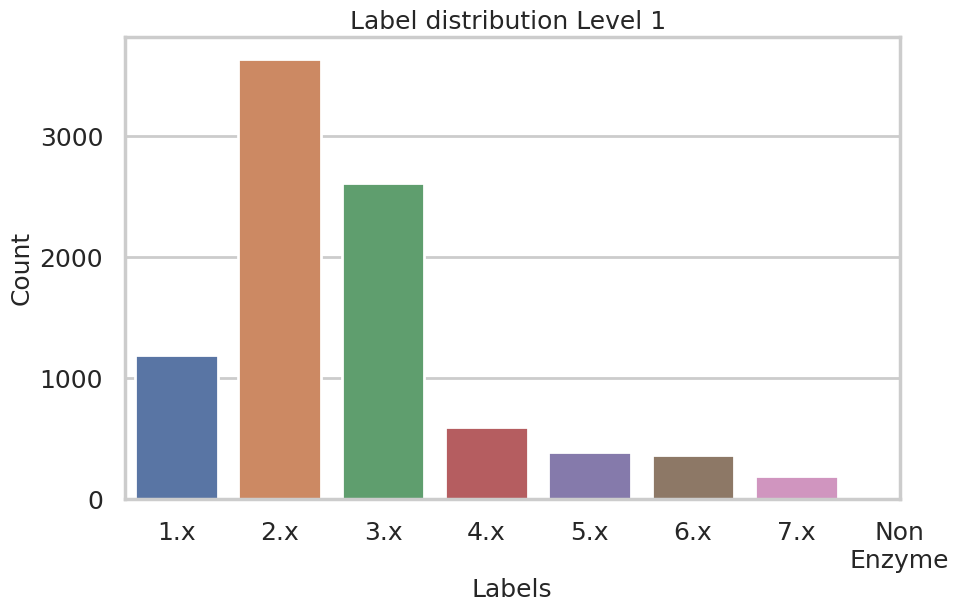

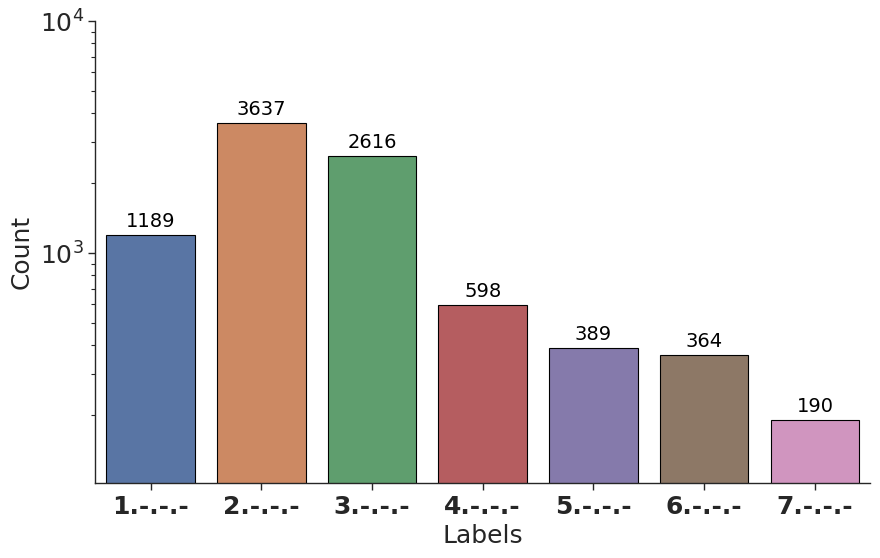

In [9]:
# Plot fore level 1
sns.set_palette("colorblind")
sns.set("poster")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.set_style("whitegrid")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

countplot = sns.countplot(x=y_enzymes)
countplot.set_xticklabels(countplot.get_xticklabels())

# Add labels and title
plt.title("Label distribution Level 1 ", fontsize=18)
plt.xlabel("Labels", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ["1.x", "2.x", "3.x", "4.x", "5.x", "6.x", "7.x", "Non\nEnzyme"])
# Show the plot
plt.show()




# Plot fore level 1
sns.set_palette("colorblind")
sns.set("paper")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.set_style("ticks")
plt.xticks(fontsize=18, weight='bold')
plt.yticks(fontsize=18)
plt.ylim(102, 10000)

countplot = sns.countplot(x=y_enzymes, edgecolor='black')
countplot.set_xticklabels(countplot.get_xticklabels())
# Annotate each bar with its value
for p in countplot.patches:
    countplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=14, color='black', xytext=(0, 10),
                       textcoords='offset points')
plt.yscale('log')

plt.xticks([0, 1, 2, 3, 4, 5, 6], ["1.-.-.-", "2.-.-.-", "3.-.-.-", "4.-.-.-", "5.-.-.-", "6.-.-.-", "7.-.-.-"])
# Add labels and title

plt.title("", fontsize=18)
plt.xlabel("Labels", fontsize=18)
plt.ylabel("Count", fontsize=18)
sns.despine()
# Show the plot
plt.show()




# Splitting data

In [27]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=8)
print(y_test_encoded[0])

# file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/only_enzyme_models# /y_train_level_1_lables.txt"
# np.savetxt(file_path, y_train, delimiter=',', fmt='%d')


[0. 0. 0. 0. 0. 0. 0. 1.]


# Creating FNN

In [9]:
# Initializing the model
model = tf.keras.models.Sequential()

earl_stop = tf.keras.callbacks.EarlyStopping(patience=5)

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=8, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Training FNN

In [10]:
model.fit(x=X_train, y=y_train_encoded, epochs=7, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/7


2023-09-13 16:57:56.154595: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1893744640 exceeds 10% of free system memory.


5777/5780 [============================>.] - ETA: 0s - loss: 0.4534

2023-09-13 16:58:55.216305: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 811612160 exceeds 10% of free system memory.


5780/5780 [==============================] - 64s 11ms/step - loss: 0.4532 - val_loss: 0.1621
Epoch 2/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.2294 - val_loss: 0.1271
Epoch 3/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.1927 - val_loss: 0.1142
Epoch 4/7
5780/5780 [==============================] - 60s 10ms/step - loss: 0.1691 - val_loss: 0.1076
Epoch 5/7
5780/5780 [==============================] - 62s 11ms/step - loss: 0.1538 - val_loss: 0.0962
Epoch 6/7
5780/5780 [==============================] - 60s 10ms/step - loss: 0.1433 - val_loss: 0.0918
Epoch 7/7
5780/5780 [==============================] - 61s 11ms/step - loss: 0.1353 - val_loss: 0.0899


# Evaluation

# Testing Optuna for hyperparams

In [28]:
def objective(trial):
    # Define hyperparameters to be optimized
    num_units_dense_1 = trial.suggest_int('num_units_dense_1', 32, 256)
    dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.7)
    num_units_dense_2 = trial.suggest_int('num_units_dense_2', 16, 64)
    
    # Create the model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_units_dense_1, activation='relu', input_shape=(2560,)))
    model.add(tf.keras.layers.Dropout(dropout_rate_1))
    model.add(tf.keras.layers.Dense(units=num_units_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dense(units=8, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Split your data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
    y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=8)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    # Define early stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(patience=10)
    
    # Train the model
    history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=35, callbacks=[early_stop], verbose=0, class_weight=class_weight_dict)
    
    # Get the best validation loss
    val_loss = min(history.history['val_loss'])
    
    return val_loss

In [29]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=45)  # You can adjust the number of trials as needed

[I 2023-12-15 19:38:22,064] A new study created in memory with name: no-name-ed803874-cca0-408a-9f0c-065fcb19a938
[I 2023-12-15 19:43:39,310] Trial 0 finished with value: 0.40860044956207275 and parameters: {'num_units_dense_1': 244, 'dropout_rate_1': 0.20466596417090563, 'num_units_dense_2': 62}. Best is trial 0 with value: 0.40860044956207275.
[I 2023-12-15 19:46:53,253] Trial 1 finished with value: 0.4120672643184662 and parameters: {'num_units_dense_1': 202, 'dropout_rate_1': 0.39562535850120384, 'num_units_dense_2': 21}. Best is trial 0 with value: 0.40860044956207275.
[I 2023-12-15 19:48:55,731] Trial 2 finished with value: 0.43121013045310974 and parameters: {'num_units_dense_1': 152, 'dropout_rate_1': 0.1439870091258095, 'num_units_dense_2': 29}. Best is trial 0 with value: 0.40860044956207275.
[I 2023-12-15 19:51:36,327] Trial 3 finished with value: 0.4502657949924469 and parameters: {'num_units_dense_1': 157, 'dropout_rate_1': 0.47326951575669046, 'num_units_dense_2': 26}. Be

KeyboardInterrupt: 

[I 2023-10-15 10:50:52,605] Trial 21 finished with value: 0.46775954961776733 and parameters: {'num_units_dense_1': 435, 'dropout_rate_1': 0.6271616990140565, 'num_units_dense_2': 214, 'dropout_rate_2': 0.11491633226586015, 'num_units_dense_3': 90}. Best is trial 21 with value: 0.46775954961776733.

Trial 23 finished with value: 0.442497581243515 and parameters: {'num_units_dense_1': 435, 'dropout_rate_1': 0.6283712630836917, 'num_units_dense_2': 157, 'dropout_rate_2': 0.34594360535817104, 'num_units_dense_3': 107}. Best is trial 23 with value: 0.442497581243515.

# all non enzymes with weights
[I 2023-12-15 21:17:11,949] Trial 33 finished with value: 0.3809511959552765 and parameters: {'num_units_dense_1': 168, 'dropout_rate_1': 0.07889805610819639, 'num_units_dense_2': 43}. Best is trial 33 with value: 0.3809511959552765.

In [24]:
# best_num_units_dense_1 = 435
# best_dropout_rate_1 = 0.6283712630836917
# best_num_units_dense_2 = 157
# best_dropout_rate_2 = 0.34594360535817104
# best_num_units_dense_3 = 107

# less nodes 1
#[I 2023-12-11 21:47:29,653] Trial 17 finished with value: 0.23831643164157867 and parameters: {'num_units_dense_1': 212, 'dropout_rate_1': 0.34140714797987826, 'num_units_dense_2': 36}. Best is trial 17 with value: 0.23831643164157867. 


# less nodes 2
#{'num_units_dense_1': 255, 'dropout_rate_1': 0.6763562286580183, 'num_units_dense_2': 32} 

# best_params = study.best_params
# best_params = {'num_units_dense_1': 255, 'dropout_rate_1': 0.6763562286580183, 'num_units_dense_2': 32} 
best_params = {'num_units_dense_1': 168, 'dropout_rate_1': 0.07889805610819639, 'num_units_dense_2': 43}
best_num_units_dense_1 = best_params['num_units_dense_1']
best_dropout_rate_1 = best_params['dropout_rate_1']
best_num_units_dense_2 = best_params['num_units_dense_2']

final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_1, activation='relu', input_shape=(2560,)))
final_model.add(tf.keras.layers.Dropout(best_dropout_rate_1))
final_model.add(tf.keras.layers.Dense(units=best_num_units_dense_2, activation='relu'))
final_model.add(tf.keras.layers.Dense(units=8, activation='softmax'))
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=8)

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=15)

final_model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=100, callbacks=[early_stop], verbose=1, class_weight=class_weight_dict)

Epoch 1/100
1014/1014 [==============================] - 8s 7ms/step - loss: 1.5389 - accuracy: 0.6092 - val_loss: 0.8935 - val_accuracy: 0.7218
Epoch 2/100
1014/1014 [==============================] - 7s 7ms/step - loss: 0.9078 - accuracy: 0.7336 - val_loss: 0.5897 - val_accuracy: 0.8151
Epoch 3/100
1014/1014 [==============================] - 7s 7ms/step - loss: 0.6632 - accuracy: 0.7736 - val_loss: 0.6471 - val_accuracy: 0.8096
Epoch 4/100
1014/1014 [==============================] - 7s 7ms/step - loss: 0.5234 - accuracy: 0.7967 - val_loss: 0.7051 - val_accuracy: 0.7820
Epoch 5/100
1014/1014 [==============================] - 7s 7ms/step - loss: 0.4271 - accuracy: 0.8216 - val_loss: 0.8839 - val_accuracy: 0.7347
Epoch 6/100
1014/1014 [==============================] - 7s 7ms/step - loss: 0.3687 - accuracy: 0.8267 - val_loss: 0.6131 - val_accuracy: 0.8073
Epoch 7/100
1014/1014 [==============================] - 7s 7ms/step - loss: 0.3190 - accuracy: 0.8374 - val_loss: 0.4764 - val_ac

<Figure size 1000x600 with 0 Axes>

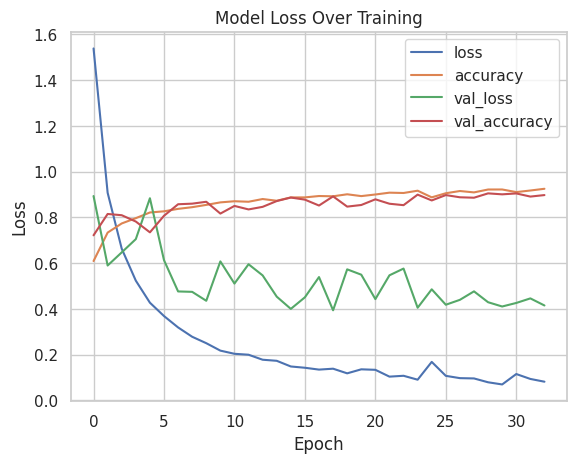

In [25]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(final_model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [26]:
predictions = np.argmax(final_model.predict(X_val), axis=-1)

counter = 0
for x,y in zip(y_val,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_val))

435/435 [==============================] - 1s 2ms/step
Correct predictions:  12477
Total samples predicted: 13899


In [33]:
y_non_enzymes

array([7, 7, 7, ..., 7, 7, 7])

In [28]:
predictions

array([7, 7, 7, ..., 7, 7, 7])

In [34]:
report = classification_report(y_val, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.55      0.86      0.67       353
           1       0.77      0.78      0.77      1130
           2       0.67      0.83      0.74       821
           3       0.49      0.64      0.56       185
           4       0.62      0.63      0.63       121
           5       0.70      0.91      0.79       112
           6       0.37      0.71      0.49        63
           7       0.97      0.92      0.95     11114

    accuracy                           0.90     13899
   macro avg       0.64      0.79      0.70     13899
weighted avg       0.91      0.90      0.90     13899


In [35]:
final_model.save("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/1512_opt_less_nodes_2_weighted.keras")
